# Exercise 9

## Mashable news stories analysis

Predicting if a news story is going to be popular


In [1]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/mashable.csv'
df = pd.read_csv(url, index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [2]:
df.shape

(6000, 61)

In [3]:
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

In [4]:
y.mean()

0.5

In [5]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Exercise 9.1

Estimate a Decision Tree Classifier and a Logistic Regresion

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

models = {'Decision Tree': DecisionTreeClassifier(random_state=1),
          'Logistic Regression': LogisticRegression(solver='liblinear')}

#iterate over each model
for model in models.keys():
    models[model].fit(X_train, y_train)

# predict test for each model
y_pred = pd.DataFrame(columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)

#comparing models
results = []
for model in models.keys():
    results.append({'Accuracy':accuracy_score(y_pred[model],y_test),'F-1 Score': f1_score(y_pred[model],y_test)})
    
results = pd.DataFrame(data=results, index=models.keys())
results

,Accuracy,F-1 Score
Decision Tree,0.542667,0.540214
Logistic Regression,0.617333,0.601942


# Exercise 9.2

Estimate 300 bagged samples

Estimate the following set of classifiers:

* 100 Decision Trees where max_depth=None
* 100 Decision Trees where max_depth=2
* 100 Logistic Regressions

In [7]:
np.random.seed(111)

n_samples = X_train.shape[0]
n_estimators = 300

# create 300 bootstrap samples
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for i in range(n_estimators)]

In [8]:
np.random.seed(111) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees_log = {}

#100 Decision Trees where max_depth=None
for i in range(0,100):
    trees_log[i] = DecisionTreeClassifier(max_depth=None, random_state=seeds[i])
    trees_log[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

#100 Decision Trees where max_depth=2
for i in range(100,200):
    trees_log[i] = DecisionTreeClassifier(max_depth=2, random_state=seeds[i])
    trees_log[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

#100 Logistic Regressions
for i in range(200,300):
    trees_log[i] = LogisticRegression(solver='liblinear',random_state=seeds[i])
    trees_log[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [9]:
#Prediction for 100 Decision Trees where max_depth=None
y_pred_df_dt = pd.DataFrame(index=X_test.index, columns=list(range(0,100)))
for i in range(0,100):
    y_pred_df_dt.iloc[:, i] = trees_log[i].predict(X_test)

#Prediction for 100 Decision Trees where max_depth=2
y_pred_df_dt_2 = pd.DataFrame(index=X_test.index, columns=list(range(0,300)))
for i in range(100,200):
    y_pred_df_dt_2.iloc[:, i] = trees_log[i].predict(X_test)
y_pred_df_dt_2 = y_pred_df_dt_2.loc[:, 100:199]
y_pred_df_dt_2.head()

#Prediction for 100 Logistic Regressions
y_pred_df_lr = pd.DataFrame(index=X_test.index, columns=list(range(0,300)))
for i in range(200,300):
    y_pred_df_lr.iloc[:, i] = trees_log[i].predict(X_test)
y_pred_df_lr = y_pred_df_lr.iloc[:, 200:300]
y_pred_df_lr.head()

    
y_pred_dt = (y_pred_df_dt.sum(axis=1) >= 100 / 2).astype(np.int)
y_pred_dt_2 = (y_pred_df_dt_2.sum(axis=1) >= 100 / 2).astype(np.int)
y_pred_lr = (y_pred_df_lr.sum(axis=1) >= 100 / 2).astype(np.int)

#Metrics for 100 Decision Trees where max_depth=None
dt_acc = accuracy_score(y_pred_dt, y_test)
dt_f1 = f1_score(y_pred_dt, y_test)

#Metrics for 100 Decision Trees where max_depth=2
dt_acc_2 = accuracy_score(y_pred_dt_2, y_test)
dt_f1_2 = f1_score(y_pred_dt_2, y_test)

#Metrics for 100 Logistic Regressions
lr_acc = accuracy_score(y_pred_lr, y_test)
lr_f1 = f1_score(y_pred_lr, y_test)

print('100 Decision Trees(max_depth=None)')
print('Accuracy:',dt_acc)
print('F-1 Score:',dt_f1)
print('-----------------------')
print('100 Decision Trees(max_depth=2)')
print('Accuracy:',dt_acc_2)
print('F-1 Score:',dt_f1_2)
print('-----------------------')
print('100 Logistic Regression')
print('Accuracy:',lr_acc)
print('F-1 Score:',lr_f1)

100 Decision Trees(max_depth=None)
Accuracy: 0.6466666666666666
F-1 Score: 0.6517739816031538
-----------------------
100 Decision Trees(max_depth=2)
Accuracy: 0.6426666666666667
F-1 Score: 0.639300134589502
-----------------------
100 Logistic Regression
Accuracy: 0.6226666666666667
F-1 Score: 0.603641456582633


# Exercise 9.3

Ensemble using majority voting

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [10]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees_log[i].predict(X_test)
    
y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1483,1,0,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2185,1,0,1,1,1,1,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
2520,1,1,0,1,0,0,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
3721,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3727,1,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

majority_acc = accuracy_score(y_pred, y_test)
majority_f1 = f1_score(y_pred, y_test)

print('Accuracy:',majority_acc)
print('F-1 Score:',majority_f1)

Accuracy: 0.64
F-1 Score: 0.6255201109570042


# Exercise 9.4

Estimate the probability as %models that predict positive

Modify the probability threshold and select the one that maximizes the F1-Score

In [12]:
y_pred_pos = y_pred.sum() / len(y_pred)
y_pred_pos

0.4573333333333333

Best threshold:  0.14 F1-Score: 0.7119363395225464


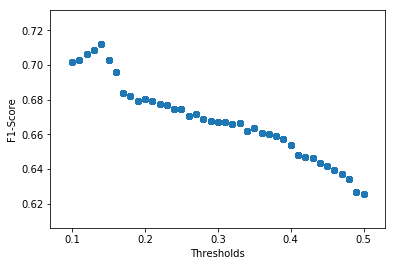

In [13]:
thresholds = []
for thresh in np.arange(0.1,0.501, 0.001):
    thresh = np.round(thresh, 2)
    res = f1_score(y_test, (y_pred_df.sum(axis=1) >= (n_estimators * thresh)).astype(int))
    thresholds.append([thresh,res])
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
best_f1_score = thresholds[0][1]
print("Best threshold: ", best_thresh,'F1-Score:',best_f1_score)

%matplotlib inline
import matplotlib.pyplot as plt
x, y = zip(*thresholds)
plt.scatter(x,y)
plt.ylabel('F1-Score')
plt.xlabel('Thresholds')
plt.show()

# Exercise 9.5

Ensemble using weighted voting using the oob_error

Evaluate using the following metrics:
* Accuracy
* F1-Score

**Select each oob sample**

In [14]:
samples_oob = []

# show the "out-of-bag" observations for each sample
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

**Estimate the oob error of each classifier**

In [15]:
errors = np.zeros(n_estimators)

for i in range(0,100):
    y_pred_ = trees_log[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

for i in range(100,200):
    y_pred_ = trees_log[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

for i in range(200,300):
    y_pred_ = trees_log[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

Text(0.5, 1.0, 'OOB error of each tree (max_depth=None)')

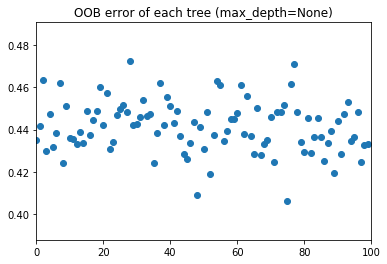

In [16]:
plt.scatter(range(0,100), errors[0:100])
plt.xlim([0, 100])
plt.title('OOB error of each tree (max_depth=None)')

Text(0.5, 1.0, 'OOB error of each tree (max_depth=2)')

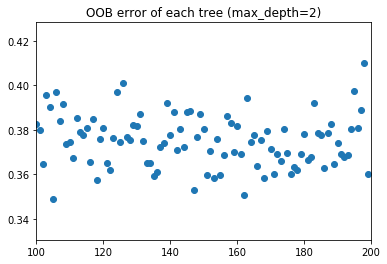

In [17]:
plt.scatter(range(100,200), errors[100:200])
plt.xlim([100, 200])
plt.title('OOB error of each tree (max_depth=2)')

Text(0.5, 1.0, 'OOB error of each Logistic Regression')

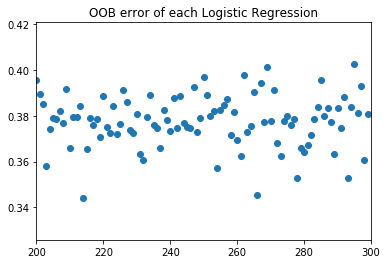

In [18]:
plt.scatter(range(200,300), errors[200:300])
plt.xlim([200, 300])
plt.title('OOB error of each Logistic Regression')

**Estimate $\alpha$**

In [19]:
alpha = (1 - errors) / (1 - errors).sum()

In [20]:
weighted_sum = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum.head(5)

1483    0.929324
2185    0.895182
2520    0.848218
3721    0.884949
3727    0.077192
dtype: float64

In [21]:
y_pred = (weighted_sum >= 0.5).astype(np.int)

weighted_acc = accuracy_score(y_pred, y_test)
weighted_f1 = f1_score(y_pred, y_test)

print('Accuracy:',weighted_acc)
print('F-1 Score:',weighted_f1)

Accuracy: 0.6406666666666667
F-1 Score: 0.6254343293954134


# Exercise 9.6

Estimate the probability of the weighted voting

Modify the probability threshold and select the one that maximizes the F1-Score

In [22]:
y_pred_pos = y_pred.sum() / len(y_pred)
y_pred_pos

0.4553333333333333

Best threshold:  0.13 F1-Score: 0.7092348284960422


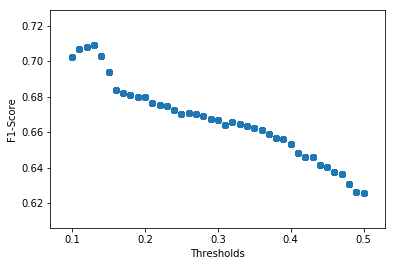

In [23]:
thresholds = []
for thresh in np.arange(0.1,0.501, 0.001):
    thresh = np.round(thresh, 2)
    res = f1_score(y_test, (weighted_sum >= thresh).astype(int))
    thresholds.append([thresh,res])
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
best_f1_score = thresholds[0][1]
print("Best threshold: ", best_thresh,'F1-Score:',best_f1_score)

%matplotlib inline
import matplotlib.pyplot as plt
x, y = zip(*thresholds)
plt.scatter(x,y)
plt.ylabel('F1-Score')
plt.xlabel('Thresholds')
plt.show()

# Exercise 9.7

Estimate a logistic regression using as input the estimated classifiers

Modify the probability threshold such that maximizes the F1-Score

In [24]:
X_train_2 = pd.DataFrame(index=X_train.index, columns=list(range(n_estimators)))

for i in range(0, 100):
    X_train_2[i] = trees_log[i].predict(X_train)

for i in range(100, 200):
    X_train_2[i] = trees_log[i].predict(X_train)
    
for i in range(200, 300):
    X_train_2[i] = trees_log[i].predict(X_train)

In [25]:
X_train_2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
2420,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1225,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
324,1,0,1,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
5863,1,0,1,1,0,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
86,1,1,1,1,0,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1


In [26]:
from sklearn.linear_model import LogisticRegressionCV

In [27]:
lr = LogisticRegressionCV(cv = 5)
lr.fit(X_train_2, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [28]:
lr.coef_

array([[0.03477156, 0.03315128, 0.03267667, 0.03472701, 0.03387833,
        0.0347765 , 0.0337944 , 0.032922  , 0.03439989, 0.03334572,
        0.03418768, 0.03408931, 0.03422829, 0.03353003, 0.03451793,
        0.0333781 , 0.03422397, 0.03436565, 0.03374108, 0.03265968,
        0.03451014, 0.03314435, 0.03439023, 0.03389199, 0.03303562,
        0.03319928, 0.03310443, 0.03405292, 0.03228877, 0.03374677,
        0.03359154, 0.03356843, 0.03354061, 0.03380087, 0.0342601 ,
        0.03448389, 0.03469949, 0.03288886, 0.03420737, 0.033813  ,
        0.03367815, 0.03364314, 0.03358999, 0.03391867, 0.03473143,
        0.03449637, 0.03502952, 0.03368402, 0.0352278 , 0.0339163 ,
        0.03466894, 0.03362128, 0.03555121, 0.03435594, 0.03360872,
        0.03347201, 0.03363641, 0.0339456 , 0.03367525, 0.03372893,
        0.03356634, 0.03331287, 0.03425045, 0.0331551 , 0.03411797,
        0.03445486, 0.03340942, 0.03484127, 0.03477382, 0.03412827,
        0.03344546, 0.03382725, 0.03337155, 0.03

In [29]:
y_pred = lr.predict(y_pred_df)

In [30]:
logistic_acc = accuracy_score(y_pred, y_test)
logistic_f1 = f1_score(y_pred, y_test)

print('Accuracy:',logistic_acc)
print('F-1 Score:',logistic_f1)

Accuracy: 0.6453333333333333
F-1 Score: 0.6439089692101739


In [31]:
results.loc['100 Decision Trees (max_depth=None)'] = [dt_acc, dt_f1]
results.loc['100 Decision Trees (max_depth=2)'] = [dt_acc_2, dt_f1_2]
results.loc['100 Logistic Regression'] = [lr_acc, lr_f1]
results.loc['Majority Voting'] = [majority_acc, majority_f1]
results.loc['Weighted Voting'] = [weighted_acc, weighted_f1]
results.loc['Stacking w/ Logistic'] = [logistic_acc, logistic_f1]
results

,Accuracy,F-1 Score
Decision Tree,0.542667,0.540214
Logistic Regression,0.617333,0.601942
100 Decision Trees (max_depth=None),0.646667,0.651774
100 Decision Trees (max_depth=2),0.642667,0.639300
100 Logistic Regression,0.622667,0.603641
Majority Voting,0.640000,0.625520
Weighted Voting,0.640667,0.625434
Stacking w/ Logistic,0.645333,0.643909
